In [1]:
import torch
import matplotlib.pyplot as plt
import os
import requests
from io import BytesIO
import imageio
from tqdm import tqdm
import numpy as np
from scipy.ndimage import gaussian_filter


## Random seed
seed = 1287632
torch.manual_seed(seed)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

### Load data to fit

(625, 625) 0.47828797 0.53807867 0.50852394


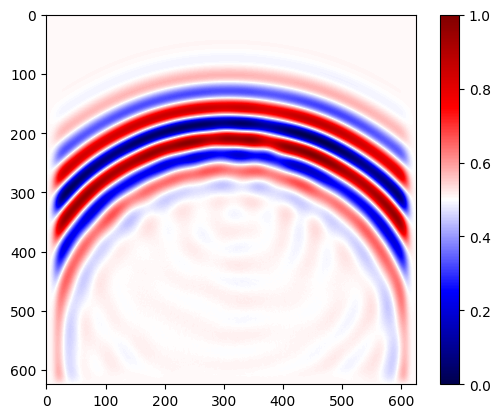

In [2]:
data = np.load("/home/stan/data/pinn/src/0725_forwardwave.npz")["data"][250]
# data = np.expand_dims(data, axis=-1)
min_val = np.min(data)
max_val = np.max(data)
average = np.mean(data)
print(data.shape, min_val,max_val, average)
data = (data - min_val) / (max_val - min_val)
plt.imshow(data,cmap="seismic")
plt.colorbar()
plt.show()

# sigma = 2 # Standard deviation for Gaussian kernel
# data_gaussianblur = gaussian_filter(data, sigma=sigma)

# # Visualize the filtered data
# plt.imshow(data_gaussianblur, cmap="seismic")
# plt.colorbar()
# plt.show()

# # Fourier transform
# f_transform = np.fft.fft2(data)
# f_transform_shifted = np.fft.fftshift(f_transform)

# # Create a low-pass filter mask
# rows, cols = data.shape
# crow, ccol = rows // 2, cols // 2  # Center
# cutoff = 120  # Cutoff frequency (adjustable for filtering)
# mask = np.zeros((rows, cols), dtype=np.float32)
# mask[crow-cutoff:crow+cutoff, ccol-cutoff:ccol+cutoff] = 1

# # Apply the mask and inverse FFT
# filtered_shifted = f_transform_shifted * mask
# filtered = np.fft.ifftshift(filtered_shifted)
# data_lowpass = np.fft.ifft2(filtered)
# data_lowpass = np.abs(data_lowpass)

# # Visualize the filtered data
# plt.imshow(data_lowpass, cmap='seismic')
# plt.colorbar()
# plt.title('Filtered Data with Fourier-based Low-pass Filter')
# plt.show()
dataset = [np.expand_dims(data, axis = -1)]


### Defined input

In [3]:

RES = 625
# x1 = np.linspace(0, 1, RES//2+1)[:-1]
x1 = np.linspace(0, 1, RES+1)[:-1]
x_train = np.stack(np.meshgrid(x1,x1), axis=-1) # 2D
# x_train = np.stack(np.meshgrid(x1,x1,x1), axis=-1) # 3D
x_train = torch.tensor(x_train, dtype=torch.float32)

x1_t = np.linspace(0, 1, RES+1)[:-1]
x_test = np.stack(np.meshgrid(x1_t,x1_t), axis=-1)
x_test = torch.tensor(x_test, dtype=torch.float32)

### Define DNN

In [4]:
import torch
import torch.nn as nn

class FNN(nn.Module):
    def __init__(self, input_dim=2, hiddenlayer_dim = 256,output_dim=1):
        super(FNN, self).__init__()
        self.l1 = nn.Sequential(
            nn.Linear(input_dim, hiddenlayer_dim),
            nn.ReLU(),
            nn.Linear(hiddenlayer_dim, hiddenlayer_dim),
            nn.ReLU(),
            nn.Linear(hiddenlayer_dim, hiddenlayer_dim),
            nn.ReLU(),
        )
        self.l2 = nn.Sequential(
            nn.Linear(hiddenlayer_dim, output_dim),
            nn.Sigmoid(),
        )
    def forward(self, x):
        y = self.l1(x)
        y = self.l2(y)
        return y

### Train

 10%|▉         | 499/5000 [02:51<32:36,  2.30it/s]

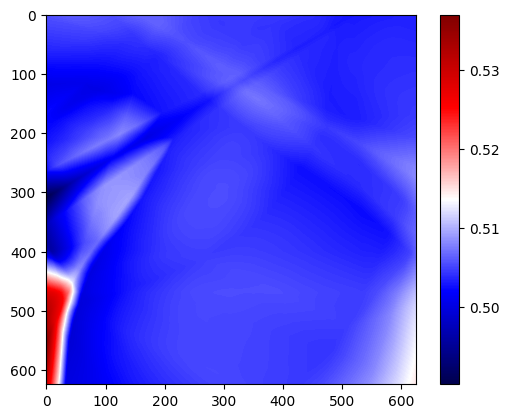

 10%|█         | 501/5000 [02:52<30:02,  2.50it/s]

Epoch 500/5000, Loss: 0.0160


 20%|█▉        | 999/5000 [05:36<26:13,  2.54it/s]

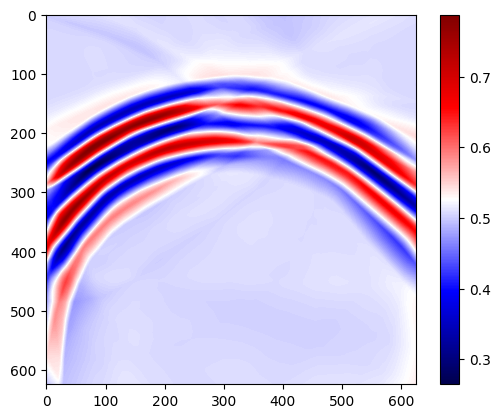

 20%|██        | 1000/5000 [05:37<29:38,  2.25it/s]

Epoch 1000/5000, Loss: 0.0150


 30%|██▉       | 1499/5000 [08:23<23:38,  2.47it/s]

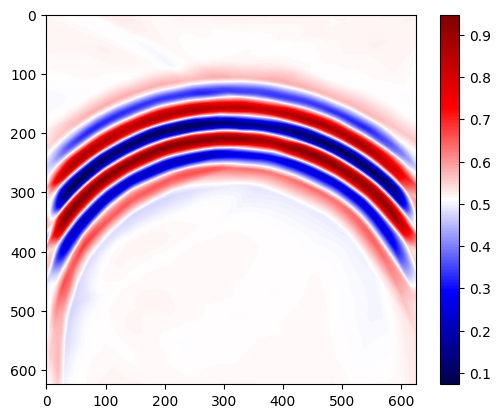

 30%|███       | 1500/5000 [08:24<30:07,  1.94it/s]

Epoch 1500/5000, Loss: 0.0107


 40%|███▉      | 1999/5000 [11:06<23:34,  2.12it/s]

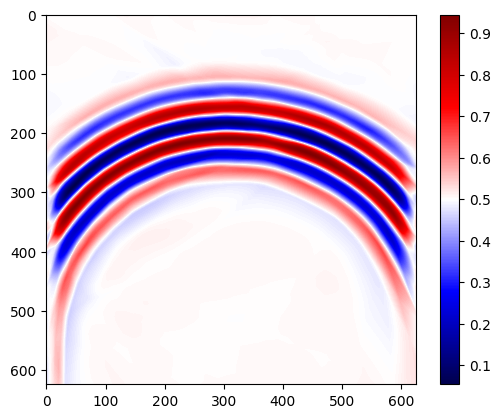

 40%|████      | 2000/5000 [11:07<26:21,  1.90it/s]

Epoch 2000/5000, Loss: 0.0081


 50%|████▉     | 2499/5000 [13:47<15:06,  2.76it/s]

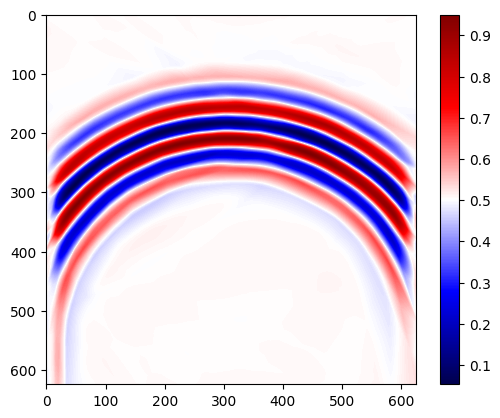

 50%|█████     | 2500/5000 [13:48<21:51,  1.91it/s]

Epoch 2500/5000, Loss: 0.0065


 60%|█████▉    | 2999/5000 [16:23<12:52,  2.59it/s]

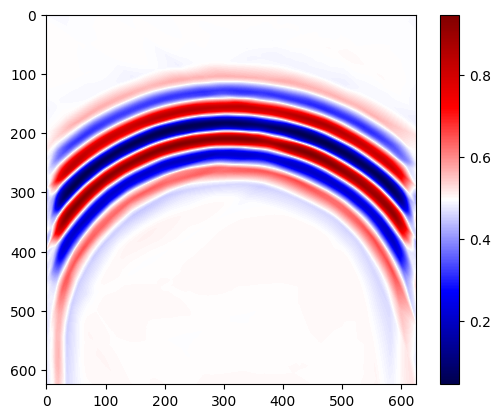

 60%|██████    | 3000/5000 [16:23<14:41,  2.27it/s]

Epoch 3000/5000, Loss: 0.0055


 70%|██████▉   | 3499/5000 [19:04<10:01,  2.50it/s]

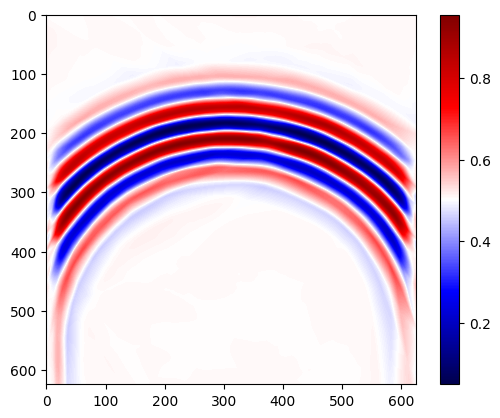

 70%|███████   | 3500/5000 [19:05<11:15,  2.22it/s]

Epoch 3500/5000, Loss: 0.0047


 80%|███████▉  | 3999/5000 [21:44<06:32,  2.55it/s]

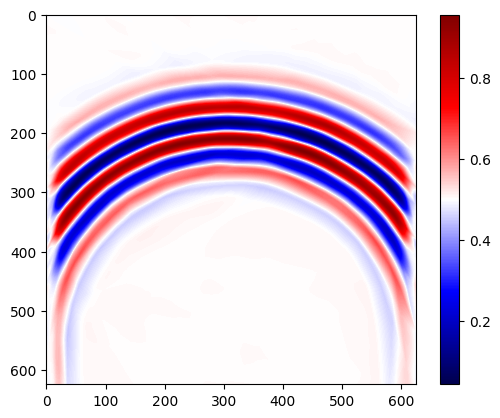

 80%|████████  | 4000/5000 [21:45<07:30,  2.22it/s]

Epoch 4000/5000, Loss: 0.0041


 90%|████████▉ | 4499/5000 [24:30<03:22,  2.47it/s]

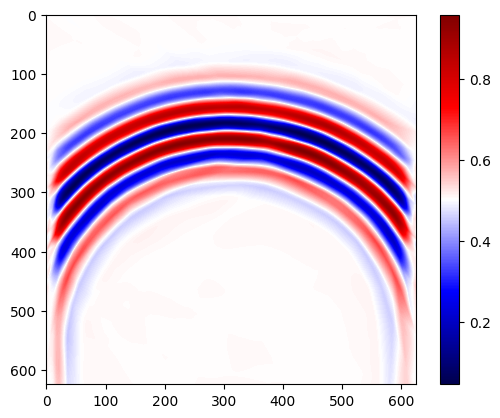

 90%|█████████ | 4500/5000 [24:31<03:52,  2.15it/s]

Epoch 4500/5000, Loss: 0.0037


100%|█████████▉| 4999/5000 [27:19<00:00,  2.11it/s]

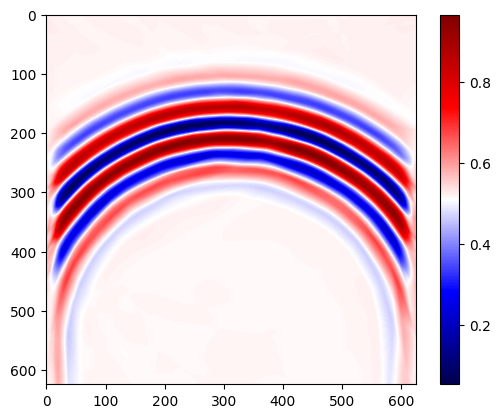

100%|██████████| 5000/5000 [27:19<00:00,  3.05it/s]

Epoch 5000/5000, Loss: 0.0033


In [5]:
import torch.optim as optim
device = torch.device("cuda:1" if (torch.cuda.is_available()) else "cpu")
train_dict ={}
def train_model(dataset , epochs):
    for img_gt in dataset:
        train_losses= []
        x = x_train.to(device)
        y = torch.tensor(img_gt, dtype=torch.float32).to(device)

        model = FNN(input_dim=2, hiddenlayer_dim= 625,output_dim=1)
        mse_loss_fn = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        model.train()
        
        for epoch in tqdm(range(epochs)):
            model.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = mse_loss_fn(output, y)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            if (epoch+1) % 500 == 0:
                output = output.detach().cpu().numpy()
                plt.imshow(output,cmap="seismic")
                plt.colorbar()
                plt.show()
                avg_train_loss = sum(train_losses) / len(train_losses)
                print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_train_loss:.4f}")
                
        train_dict["model"] = model.state_dict()
        train_dict["optimizer"] = optimizer.state_dict()
        train_dict["output"] = output
        
train_model(dataset , epochs=5000)
